# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.sql import Window
from pyspark.sql import Row, functions as F
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as funcs

import datetime
import re
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.master', 'local'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '5f50cd5556ad'),
 ('spark.driver.port', '34037'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.id', 'local-1576356671684')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
sparkify_event_data = 'mini_sparkify_event_data.json'

In [6]:
sp_df_raw = spark.read.json(sparkify_event_data)

In [8]:
# Null value counts for each column
sp_df_raw.select([funcs.count(funcs.when(funcs.isnull(c), c)).alias(c) 
                  for c in sp_df_raw.columns]).take(1)

[Row(artist=58392, auth=0, firstName=8346, gender=8346, itemInSession=0, lastName=8346, length=58392, level=0, location=8346, method=0, page=0, registration=8346, sessionId=0, song=58392, status=0, ts=0, userAgent=8346, userId=0)]

In [10]:
# Skip removing null values, since UserID and SessionID have zero null values.
sp_df = sp_df_raw
#sp_df = sp_df_raw.na.drop()

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [8]:
sp_df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [9]:
sp_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [11]:
# Get the shape of the dataframe
print((sp_df.count(), len(sp_df.columns)))

(286500, 18)


In [12]:
# Let's explore the authorization types
sp_df.select('auth').distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [13]:
# Let's explore the page types
sp_df.select('page').distinct().show(30)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [31]:
# Let's create an hour of the day column for later analysis
get_hour = funcs.udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
sp_df = sp_df.withColumn("hour", get_hour(sp_df.ts))

In [32]:
# Create date column from ts
get_timestamp = funcs.udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).strftime("%Y-%m-%d"))
sp_df = sp_df.withColumn("dateTime", get_timestamp(sp_df.ts))
sp_df.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, phase=0, songPlay=0, hour='18', dateTime='2018-11-21')

In [13]:
# Any browsers other than Mozilla?
non_mozilla_users = sp_df.filter("userAgent not like '%Mozilla%'")
non_mozilla_users.select('userAgent').count()

0

In [17]:
# Any browsers other than Mozilla 5?
non_mozilla_5_users = sp_df.filter("userAgent not like '%Mozilla/5%'")
non_mozilla_5_users.select('userAgent').count()

0

In [18]:
# How many Mac users are there?
mac_users = sp_df.filter("userAgent like '%Mac%'")
mac_users.select('userAgent').count()

125322

In [19]:
# How many Windows users are there?
windows_users = sp_df.filter("userAgent like '%Windows%'")
windows_users.select('userAgent').count()

143871

In [30]:
# Are there other operating systems being used?
other_users = sp_df.where('userAgent not like "%Windows%" and userAgent not like "%Mac%"')
other_users.select('userAgent').count()

8961

In [12]:
# Create churn event column
flag_churn_event = funcs.udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
sp_df = sp_df.withColumn("churn", flag_churn_event("page"))

In [14]:
# Create column that classifies churned user
windowval = Window.partitionBy("userId").orderBy(funcs.desc("ts")) \
                .rangeBetween(Window.unboundedPreceding, 0)
sp_df = sp_df.withColumn("phase", funcs.sum("churn").over(windowval))

In [15]:
# Create song play column
flag_song_play_event = funcs.udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())
sp_df = sp_df.withColumn("songPlay", flag_song_play_event("page"))

In [16]:
# Seperate active and churned users for analysis
still_active = sp_df.where(sp_df['phase'] == "0")
not_active = sp_df.where(sp_df['phase'] == "1")

In [17]:
# How many active users?
still_active.select('userId').distinct().count()

174

In [19]:
# How many churned users?
not_active.select('userId').distinct().count()

52

In [192]:
# Song play counts for active users
still_active.filter(still_active.page == "NextSong") \
    .groupby(still_active.userId).count().describe().show()

+-------+------------------+------------------+
|summary|            userId|             count|
+-------+------------------+------------------+
|  count|               173|               173|
|   mean| 60756.87861271676|1108.1734104046243|
| stddev|110276.04376677402|1183.1467030410008|
|    min|                10|                 3|
|    max|                99|              8002|
+-------+------------------+------------------+



In [51]:
# Song play counts for inactive users
not_active.filter(not_active.page == "NextSong") \
    .groupby(not_active.userId).count().describe().show()

+-------+-----------------+-----------------+
|summary|           userId|            count|
+-------+-----------------+-----------------+
|  count|               52|               52|
|   mean|80808.42307692308|699.8846153846154|
| stddev| 86381.6770659117|714.7376497666588|
|    min|           100001|                8|
|    max|               87|             3028|
+-------+-----------------+-----------------+



In [189]:
# Thumbs up counts for active users
still_active.filter(still_active.page == "Thumbs Up") \
    .groupby(still_active.userId).count().describe().show()

+-------+------------------+-----------------+
|summary|            userId|            count|
+-------+------------------+-----------------+
|  count|               170|              170|
|   mean| 61826.81764705882|62.89411764705882|
| stddev|110951.66714991374|70.55134074678884|
|    min|                10|                1|
|    max|                99|              437|
+-------+------------------+-----------------+



In [191]:
# Thumbs up counts for not active users
not_active.filter(not_active.page == "Thumbs Up") \
    .groupby(not_active.userId).count().describe().show()

+-------+-----------------+-----------------+
|summary|           userId|            count|
+-------+-----------------+-----------------+
|  count|               50|               50|
|   mean|         82038.04|            37.18|
| stddev|87318.01473431026|39.82445664335893|
|    min|           100001|                1|
|    max|               87|              163|
+-------+-----------------+-----------------+



In [193]:
# Thumbs down counts for active users
still_active.filter(still_active.page == "Thumbs Down") \
    .groupby(still_active.userId).count().describe().show()

+-------+------------------+------------------+
|summary|            userId|             count|
+-------+------------------+------------------+
|  count|               155|               155|
|   mean| 60707.66451612903|13.225806451612904|
| stddev|110753.28788812358|14.201951753145037|
|    min|                10|                 1|
|    max|                99|                75|
+-------+------------------+------------------+



In [194]:
# Thumbs down counts for not active users
not_active.filter(not_active.page == "Thumbs Down") \
    .groupby(not_active.userId).count().describe().show()

+-------+-----------------+------------------+
|summary|           userId|             count|
+-------+-----------------+------------------+
|  count|               48|                48|
|   mean|83369.64583333333|10.333333333333334|
| stddev|88303.42177570147| 9.013779837024787|
|    min|           100001|                 1|
|    max|               87|                36|
+-------+-----------------+------------------+



In [195]:
# Add Friend counts for active users
still_active.filter(still_active.page == "Add Friend") \
    .groupby(still_active.userId).count().describe().show()

+-------+------------------+------------------+
|summary|            userId|             count|
+-------+------------------+------------------+
|  count|               162|               162|
|   mean| 63024.90740740741| 22.47530864197531|
| stddev|111365.94317213274|22.322926581126953|
|    min|                10|                 1|
|    max|                99|               143|
+-------+------------------+------------------+



In [52]:
# Add Friend counts for not active users
not_active.filter(not_active.page == "Add Friend") \
    .groupby(not_active.userId).count().describe().show()

+-------+-----------------+------------------+
|summary|           userId|             count|
+-------+-----------------+------------------+
|  count|               44|                44|
|   mean|77313.84090909091|14.454545454545455|
| stddev|88539.41804168439|10.712858054485752|
|    min|           100001|                 1|
|    max|               87|                47|
+-------+-----------------+------------------+



In [196]:
# Add to playlist counts for active users
still_active.filter(still_active.page == "Add to Playlist") \
    .groupby(still_active.userId).count().describe().show()

+-------+------------------+-----------------+
|summary|            userId|            count|
+-------+------------------+-----------------+
|  count|               165|              165|
|   mean| 61275.10909090909|33.26060606060606|
| stddev|111277.15933238767|35.17758033417074|
|    min|                10|                1|
|    max|                99|              240|
+-------+------------------+-----------------+



In [197]:
# Add to playlist counts for not active users
not_active.filter(not_active.page == "Add to Playlist") \
    .groupby(not_active.userId).count().describe().show()

+-------+-----------------+------------------+
|summary|           userId|             count|
+-------+-----------------+------------------+
|  count|               50|                50|
|   mean|         82037.78|             20.76|
| stddev|87317.96010529915|21.199306881237835|
|    min|           100001|                 1|
|    max|               87|                89|
+-------+-----------------+------------------+



In [198]:
# Add to playlist counts for active users
still_active.filter(still_active.page == "Help") \
    .groupby(still_active.userId).count().describe().show()

+-------+------------------+------------------+
|summary|            userId|             count|
+-------+------------------+------------------+
|  count|               150|               150|
|   mean|63149.275167785236| 9.913333333333334|
| stddev|112287.40621382179|22.862277087957192|
|    min|                  |                 1|
|    max|                99|               272|
+-------+------------------+------------------+



In [199]:
# Add to playlist counts for not active users
not_active.filter(not_active.page == "Help") \
    .groupby(not_active.userId).count().describe().show()

+-------+-----------------+-----------------+
|summary|           userId|            count|
+-------+-----------------+-----------------+
|  count|               43|               43|
|   mean|81434.04651162791|5.558139534883721|
| stddev|90624.11417785884|5.301851992605508|
|    min|           100001|                1|
|    max|               87|               28|
+-------+-----------------+-----------------+



In [200]:
mac_usersnew = still_active.filter("userAgent like '%Mac%'")
mac_user_pct = mac_usersnew.select('userId').distinct().count() \
    / still_active.select('userId').distinct().count()
mac_user_pct

0.4540229885057471

In [201]:
mac_users_not_active = not_active.filter("userAgent like '%Mac%'")
mac_user_not_active_pct = mac_users_not_active.select('userId').distinct().count() \
    / not_active.select('userId').distinct().count()
mac_user_not_active_pct

0.4423076923076923

In [202]:
# Percentage of active users who are male
male_users = still_active.filter("gender like '%M%'")
male_user_pct = male_users.select('userId').distinct().count() \
    / still_active.select('userId').distinct().count()
male_user_pct

0.5114942528735632

In [203]:
# Looks like males are slightly more likely to cancel.
# We'll explore this further during the modeling process.
male_users_not_active = not_active.filter("gender like '%M%'")
male_user_not_active_pct = male_users_not_active.select('userId').distinct().count() \
    / not_active.select('userId').distinct().count()
male_user_not_active_pct

0.6153846153846154

In [185]:
gender_churn = not_active.select(["userId", "gender"]) \
                .dropDuplicates(["userId", "gender"]) \
                .groupby(["gender"]) \
                .count().toPandas()

Text(0.5,1,'Churn by Gender')

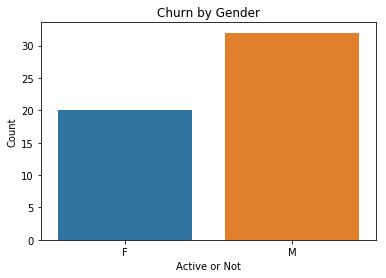

In [187]:
# Let's compare churn count by gender
ax = sns.barplot(x='gender', y='count', data=gender_churn)
plt.xlabel('Active or Not')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.title('Churn by Gender')

In [204]:
# Let's view active users listening patterns throughout the day
songs_in_hour = still_active.filter(still_active.page == "NextSong") \
    .groupby(still_active.hour).count().orderBy(still_active.hour.cast("float"))
songs_in_hour.show()
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

+----+-----+
|hour|count|
+----+-----+
|   0| 7527|
|   1| 7035|
|   2| 7014|
|   3| 7063|
|   4| 6914|
|   5| 6960|
|   6| 6836|
|   7| 6873|
|   8| 7023|
|   9| 7268|
|  10| 7502|
|  11| 7440|
|  12| 7918|
|  13| 8073|
|  14| 8792|
|  15| 9462|
|  16| 9721|
|  17| 9464|
|  18| 9146|
|  19| 9112|
+----+-----+
only showing top 20 rows



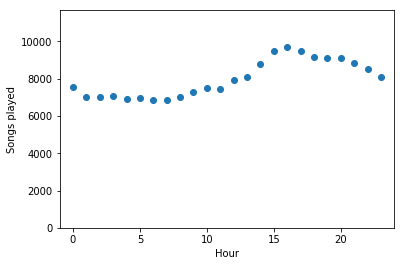

In [23]:
# Let's plot active users listening patterns throughout the day
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [205]:
# Let's view churned users listening patterns throughout the day
songs_in_hour = not_active.filter(not_active.page == "NextSong") \
    .groupby(not_active.hour).count().orderBy(not_active.hour.cast("float"))
songs_in_hour.show()
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

+----+-----+
|hour|count|
+----+-----+
|   0| 1535|
|   1| 1353|
|   2| 1322|
|   3| 1292|
|   4| 1233|
|   5| 1218|
|   6| 1218|
|   7| 1218|
|   8| 1230|
|   9| 1230|
|  10| 1380|
|  11| 1390|
|  12| 1408|
|  13| 1571|
|  14| 1702|
|  15| 1892|
|  16| 1915|
|  17| 1996|
|  18| 1978|
|  19| 1818|
+----+-----+
only showing top 20 rows



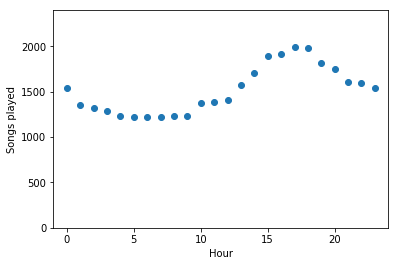

In [60]:
# Let's plot churned users listening patterns throughout the day
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [206]:
# Song play counts for active users
active_song_count = still_active.filter(still_active.page == "NextSong") \
    .groupby(still_active.userId).count()
active_song_count_pd = active_song_count.toPandas()
active_song_count_pd = active_song_count_pd.sort_values(by=['count'])
active_song_count_pd.head(10)

,userId,count
93,156,3
92,135,6
110,300003,27
24,22,28
71,68,29
19,133,32
72,90,37
123,134,37
15,64,46
18,34,53


Text(0,0.5,'Song count')

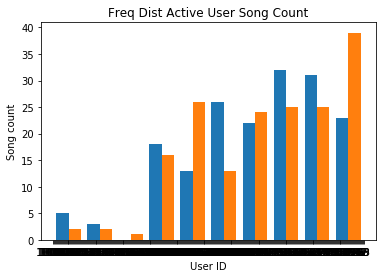

In [31]:
plt.hist(active_song_count_pd)
plt.title('Freq Dist Active User Song Count')
plt.xlabel('User ID')
plt.ylabel('Song count')

In [207]:
# Song play counts for churned users
not_active_song_count = not_active.filter(not_active.page == "NextSong") \
    .groupby(not_active.userId).count()
not_active_song_count_pd = not_active_song_count.toPandas()
not_active_song_count_pd = not_active_song_count_pd.sort_values(by=['count'])
not_active_song_count_pd.head(10)

,userId,count
0,125,8
31,100011,11
26,100024,22
14,100006,26
28,122,41
24,100003,51
45,100017,52
32,100019,62
39,32,80
38,143,101


Text(0,0.5,'Song count')

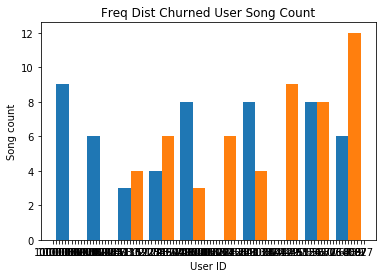

In [33]:
plt.hist(not_active_song_count_pd)
plt.title('Freq Dist Churned User Song Count')
plt.xlabel('User ID')
plt.ylabel('Song count')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [163]:
not_active.take(3)

[Row(artist=None, auth='Logged In', firstName='Mason', gender='M', itemInSession=9, lastName='Hart', length=None, level='free', location='Corpus Christi, TX', method='PUT', page='Cancel', registration=1533157139000, sessionId=174, song=None, status=307, ts=1539318918000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='125', hour='4', dateTime='2018-10-12', churn=0, phase=1, songPlay=0),
 Row(artist=None, auth='Cancelled', firstName='Mason', gender='M', itemInSession=10, lastName='Hart', length=None, level='free', location='Corpus Christi, TX', method='GET', page='Cancellation Confirmation', registration=1533157139000, sessionId=174, song=None, status=200, ts=1539318918000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='125', hour='4', dateTime='2018-10-12', churn=1, phase=1, songPlay=0),
 Row(art

### Feature Extraction

In [18]:
# Numeral Variables
trim_df = sp_df.select('userID', 'page', 'length')

In [19]:
# Create feature for song count
userSongCount = trim_df.filter((trim_df.page == 'NextSong')) \
    .groupBy('userId') \
    .agg({'page':'count'}).withColumnRenamed('count(page)', 'songCount')
userSongCount.count()

225

In [20]:
# Create feature for thumb up count
userThumbUpCount = trim_df.filter((trim_df.page == 'Thumbs Up')) \
    .groupBy('userId') \
    .agg({'page':'count'}).withColumnRenamed('count(page)', 'thumbUpCount')
userThumbUpCount.count()

220

In [21]:
# Create feature for thumb down count
userThumbDownCount = trim_df.filter((trim_df.page == 'Thumbs Down')) \
    .groupBy('userId') \
    .agg({'page':'count'}).withColumnRenamed('count(page)', 'thumbDownCount')
userThumbDownCount.count()

203

In [22]:
# Create feature for add to playlist count
userAddToPlaylistCount = trim_df.filter((trim_df.page == 'Add to Playlist')) \
    .groupBy('userId') \
    .agg({'page':'count'}).withColumnRenamed('count(page)', 'AddToPlaylistCount')
userAddToPlaylistCount.count()

215

In [23]:
# Create feature for add friend count
userAddFriendCount = trim_df.filter((trim_df.page == 'Add Friend')) \
    .groupBy('userId') \
    .agg({'page':'count'}).withColumnRenamed('count(page)', 'AddFriendCount')
userAddFriendCount.count()

206

In [24]:
# Create feature for help page visit count
userHelpCount = trim_df.filter((trim_df.page == 'Help')) \
    .groupBy('userId') \
    .agg({'page':'count'}).withColumnRenamed('count(page)', 'helpCount')
userHelpCount.count()

193

In [25]:
# Create feature for error count
userErrorCount = trim_df.filter((trim_df.page == 'Error')) \
    .groupBy('userId') \
    .agg({'page':'count'}).withColumnRenamed('count(page)', 'errorCount')
userErrorCount.count()

118

In [26]:
# Create feature for roll advert count
userRollAdvertCount = trim_df.filter((trim_df.page == 'Roll Advert')) \
    .groupBy('userId') \
    .agg({'page':'count'}).withColumnRenamed('count(page)', 'rollAdvertCount')
userRollAdvertCount.count()

207

In [27]:
# Create feature for listening time
userListeningTime = trim_df.filter((trim_df.page == 'NextSong')) \
    .groupBy('userId') \
    .agg({'length':'sum'}).withColumnRenamed('sum(length)', 'listeningTimeSec')
userListeningTime.count()

225

In [28]:
# Create dummy column for gender
label_gender = funcs.udf(lambda x: 1 if x == "M" else 0, IntegerType())
gender_df = sp_df.select('userID', 'gender')
userGender = gender_df.withColumn("Male", label_gender("gender"))
userGender = userGender.drop('gender')
userGender = userGender.dropDuplicates()

In [29]:
userGender.show(3)

+------+----+
|userID|Male|
+------+----+
|    73|   0|
|    37|   1|
|    19|   0|
+------+----+
only showing top 3 rows



In [33]:
# Create feature for average items per session
window = Window.partitionBy('userId').orderBy('dateTime')
items_session_df = sp_df.withColumn("AvgItemsPerSess", funcs.avg("itemInSession").over(window))
items_session_df = items_session_df.select('userID', 'AvgItemsPerSess')
userAvgItemsPerSess = items_session_df.dropDuplicates(['userID'])

In [34]:
userAvgItemsPerSess.show(3)

+------+---------------+
|userID|AvgItemsPerSess|
+------+---------------+
|100010|           19.5|
|200002|            3.0|
|   125|            5.0|
+------+---------------+
only showing top 3 rows



### Joining the Dataframes

In [35]:
# Using an outer join to not lose users from the analysis
user_agg_df = userSongCount.join(userThumbUpCount, "userId", how='full')
user_agg_df = user_agg_df.join(userThumbDownCount, "userId", how='full')
user_agg_df = user_agg_df.join(userAddToPlaylistCount, "userId", how='full')
user_agg_df = user_agg_df.join(userAddFriendCount, "userId", how='full')
user_agg_df = user_agg_df.join(userErrorCount, "userId", how='full')
user_agg_df = user_agg_df.join(userHelpCount, "userId", how='full')
user_agg_df = user_agg_df.join(userRollAdvertCount, "userId", how='full')
user_agg_df = user_agg_df.join(userListeningTime, "userId", how='full')
user_agg_df = user_agg_df.join(userGender, "userId", how='full')
user_agg_df = user_agg_df.join(userAvgItemsPerSess, "userId", how='full')
user_agg_df = user_agg_df.withColumn("listeningTimeSec", user_agg_df["listeningTimeSec"].cast(IntegerType()))
user_agg_df = user_agg_df.withColumn("AvgItemsPerSess", user_agg_df["AvgItemsPerSess"].cast(IntegerType()))

In [41]:
user_agg_df.count()

226

### Handling Null Values

In [42]:
# View null values
user_agg_df.select([funcs.count(funcs.when(funcs.isnull(c), c)).alias(c) for c in user_agg_df.columns]).show()

+------+---------+------------+--------------+------------------+--------------+----------+---------+---------------+----------------+----+---------------+-----------+
|userId|songCount|thumbUpCount|thumbDownCount|AddToPlaylistCount|AddFriendCount|errorCount|helpCount|rollAdvertCount|listeningTimeSec|Male|AvgItemsPerSess|NumFeatures|
+------+---------+------------+--------------+------------------+--------------+----------+---------+---------------+----------------+----+---------------+-----------+
|     0|        0|           0|             0|                 0|             0|         0|        0|              0|               0|   0|              0|          0|
+------+---------+------------+--------------+------------------+--------------+----------+---------+---------------+----------------+----+---------------+-----------+



In [43]:
# Fill null values
user_agg_df = user_agg_df.na.fill(0)

### Vectorization

In [45]:
assembler = VectorAssembler(inputCols=["songCount","thumbUpCount","thumbDownCount","AddToPlaylistCount",
                                       "AddFriendCount","errorCount","helpCount","rollAdvertCount",
                                       "listeningTimeSec", "Male", "AvgItemsPerSess"], outputCol="NumFeatures")
user_agg_df = assembler.transform(user_agg_df)

In [ ]:
user_agg_df.take(3)

### Normalize the Vectors

In [46]:
scaler = Normalizer(inputCol="NumFeatures", outputCol="ScaledNumFeatures")
user_agg_df = scaler.transform(user_agg_df)

In [47]:
user_agg_df.take(3)

[Row(userId='100010', songCount=275, thumbUpCount=17, thumbDownCount=5, AddToPlaylistCount=7, AddFriendCount=4, errorCount=0, helpCount=2, rollAdvertCount=52, listeningTimeSec=66940, Male=0, AvgItemsPerSess=19, NumFeatures=DenseVector([275.0, 17.0, 5.0, 7.0, 4.0, 0.0, 2.0, 52.0, 66940.0, 0.0, 19.0]), ScaledNumFeatures=DenseVector([0.0041, 0.0003, 0.0001, 0.0001, 0.0001, 0.0, 0.0, 0.0008, 1.0, 0.0, 0.0003])),
 Row(userId='200002', songCount=387, thumbUpCount=21, thumbDownCount=6, AddToPlaylistCount=8, AddFriendCount=4, errorCount=0, helpCount=2, rollAdvertCount=7, listeningTimeSec=94008, Male=1, AvgItemsPerSess=3, NumFeatures=DenseVector([387.0, 21.0, 6.0, 8.0, 4.0, 0.0, 2.0, 7.0, 94008.0, 1.0, 3.0]), ScaledNumFeatures=DenseVector([0.0041, 0.0002, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0001, 1.0, 0.0, 0.0])),
 Row(userId='125', songCount=8, thumbUpCount=0, thumbDownCount=0, AddToPlaylistCount=0, AddFriendCount=0, errorCount=0, helpCount=0, rollAdvertCount=1, listeningTimeSec=2089, Male=1, Avg

### Scale the Vectors

In [48]:
scaler2 = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures2", withStd=True)
scalerModel = scaler2.fit(user_agg_df)
user_agg_df = scalerModel.transform(user_agg_df)

In [49]:
user_agg_df.head(3)

[Row(userId='100010', songCount=275, thumbUpCount=17, thumbDownCount=5, AddToPlaylistCount=7, AddFriendCount=4, errorCount=0, helpCount=2, rollAdvertCount=52, listeningTimeSec=66940, Male=0, AvgItemsPerSess=19, NumFeatures=DenseVector([275.0, 17.0, 5.0, 7.0, 4.0, 0.0, 2.0, 52.0, 66940.0, 0.0, 19.0]), ScaledNumFeatures=DenseVector([0.0041, 0.0003, 0.0001, 0.0001, 0.0001, 0.0, 0.0, 0.0008, 1.0, 0.0, 0.0003]), ScaledNumFeatures2=DenseVector([0.249, 0.2598, 0.3826, 0.2141, 0.1944, 0.0, 0.1048, 2.4148, 0.2432, 0.0, 0.6289])),
 Row(userId='200002', songCount=387, thumbUpCount=21, thumbDownCount=6, AddToPlaylistCount=8, AddFriendCount=4, errorCount=0, helpCount=2, rollAdvertCount=7, listeningTimeSec=94008, Male=1, AvgItemsPerSess=3, NumFeatures=DenseVector([387.0, 21.0, 6.0, 8.0, 4.0, 0.0, 2.0, 7.0, 94008.0, 1.0, 3.0]), ScaledNumFeatures=DenseVector([0.0041, 0.0002, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0001, 1.0, 0.0, 0.0]), ScaledNumFeatures2=DenseVector([0.3504, 0.3209, 0.4591, 0.2446, 0.1944, 

### Add Churned label

In [50]:
churn_df = sp_df.select(['userID', 'phase']).withColumnRenamed('phase', 'label').dropDuplicates()

In [51]:
churn_df.count()

226

In [52]:
features_labels = user_agg_df.select(['userID', 'ScaledNumFeatures2']).withColumnRenamed('ScaledNumFeatures2', 'features').dropDuplicates()

In [53]:
features_labels = features_labels.join(churn_df, "userId", how='full')

In [54]:
features_labels = features_labels.drop('userId')

In [55]:
features_labels.take(3)

[Row(features=DenseVector([0.249, 0.2598, 0.3826, 0.2141, 0.1944, 0.0, 0.1048, 2.4148, 0.2432, 0.0, 0.6289]), label=0),
 Row(features=DenseVector([0.3504, 0.3209, 0.4591, 0.2446, 0.1944, 0.0, 0.1048, 0.3251, 0.3415, 2.0006, 0.0993]), label=0),
 Row(features=SparseVector(11, {0: 0.0072, 7: 0.0464, 8: 0.0076, 9: 2.0006, 10: 0.1655}), label=1)]

In [56]:
features_labels.count()

226

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [57]:
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

### Train, Test Split

In [58]:
# Split the data into training and test sets
training_data, test_data = features_labels.randomSplit([0.7, 0.3])

### Logisitc Regression

In [ ]:
def logistic_regression(training_data):
    """Takes in training dataset, tests hyper parameter combinations, 
    performs cross validation, evaluates, and returns best model."""
    lr = LogisticRegression()

    modelEvaluator=MulticlassClassificationEvaluator(metricName='f1')
    pipeline = Pipeline(stages=[lr])
    paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.05, 0.1, 0.3, 0.6]) \
                    .addGrid(lr.elasticNetParam, [0.2, 0.5, 1]) \
                    .addGrid(lr.family, ["binomial", "multinomial"]).build()

    crossval = CrossValidator(estimator=lr,
                              estimatorParamMaps=paramGrid,
                              evaluator=modelEvaluator,
                              parallelism=3,
                              numFolds=3)

    cvModel = crossval.fit(training_data)

    return cvModel

lr_summary = logistic_regression(training_data)

In [ ]:
lr_results = lr_summary.transform(test_data)

In [ ]:
lr_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
lr_f1 = lr_evaluator.evaluate(lr_results, {lr_evaluator.metricName: "f1"})

In [ ]:
lr_acc = lr_evaluator.evaluate(lr_results, {lr_evaluator.metricName: "accuracy"})

In [ ]:
print("F1 Score: ", lr_f1)
print("Accuracy: ", lr_acc)

### Random Forrest Trees

In [ ]:
def random_forrest(training_data):
    """Takes in training dataset, tests hyper parameter combinations, 
    performs cross validation, evaluates, and returns best model."""
    rf = RandomForestClassifier()

    modelEvaluator=MulticlassClassificationEvaluator(metricName='f1')
    pipeline = Pipeline(stages=[rf])
    paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [2, 5, 8]) \
                    .addGrid(rf.maxDepth, [2, 4, 6]).build()

    crossval = CrossValidator(estimator=rf,
                              estimatorParamMaps=paramGrid,
                              evaluator=modelEvaluator,
                              parallelism=3,
                              numFolds=3)

    cvModel = crossval.fit(training_data)

    return cvModel

rft_summary = random_forrest(training_data)

In [ ]:
rft_results = rft_summary.transform(test_data)

In [ ]:
rft_summary.bestModel

In [ ]:
rft_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
rft_f1 = rft_evaluator.evaluate(rft_results, {rft_evaluator.metricName: "f1"})

In [ ]:
rft_acc = rft_evaluator.evaluate(rft_results, {rft_evaluator.metricName: "accuracy"})

In [ ]:
print("F1 Score: ", rft_f1)
print("Accuracy: ", rft_acc)

### Gradient Boosted Trees

In [ ]:
def gradient_boosted_trees(training_data):
    """Takes in training dataset, tests hyper parameter combinations, 
    performs cross validation, evaluates, and returns best model."""
    gbt = GBTClassifier()

    modelEvaluator=MulticlassClassificationEvaluator(metricName='f1')
    pipeline = Pipeline(stages=[gbt])
    paramGrid = ParamGridBuilder().addGrid(gbt.maxIter, [2, 5]) \
                    .addGrid(gbt.seed, [15, 30]).build()

    crossval = CrossValidator(estimator=gbt,
                              estimatorParamMaps=paramGrid,
                              evaluator=modelEvaluator,
                              parallelism=3,
                              numFolds=3)

    cvModel = crossval.fit(training_data)

    return cvModel

gbt_summary = gradient_boosted_trees(training_data)

In [ ]:
gbt_results = gbt_summary.transform(test_data)

In [ ]:
gbt_summary.bestModel

In [ ]:
gbt_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
gbt_f1 = gbt_evaluator.evaluate(gbt_results, {gbt_evaluator.metricName: "f1"})

In [ ]:
gbt_acc = gbt_evaluator.evaluate(gbt_results, {gbt_evaluator.metricName: "accuracy"})

In [ ]:
print("F1 Score: ", gbt_f1)
print("Accuracy: ", gbt_acc)

### Naive Bayes

In [ ]:
def naive_bayes(training_data):
    """Takes in training dataset, tests hyper parameter combinations, 
    performs cross validation, evaluates, and returns best model."""
    nb = NaiveBayes(modelType="multinomial")

    modelEvaluator=MulticlassClassificationEvaluator(metricName='f1')
    pipeline = Pipeline(stages=[nb])
    paramGrid = ParamGridBuilder().addGrid(nb.smoothing, [1.0, 2.0]).build()

    crossval = CrossValidator(estimator=nb,
                              estimatorParamMaps=paramGrid,
                              evaluator=modelEvaluator,
                              parallelism=3,
                              numFolds=3)

    cvModel = crossval.fit(training_data)

    return cvModel

nb_summary = naive_bayes(training_data)

In [ ]:
nb_results = nb_summary.transform(test_data)

In [ ]:
nb_summary.bestModel

In [ ]:
nb_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
nb_f1 = nb_evaluator.evaluate(nb_results, {gbt_evaluator.metricName: "f1"})

In [ ]:
nb_acc = nb_evaluator.evaluate(nb_results, {nb_evaluator.metricName: "accuracy"})

In [ ]:
print("F1 Score: ", nb_f1)
print("Accuracy: ", nb_acc)

In [ ]:
print("Random Forest F1 Score: ", rft_f1)
print("Gradient Boosted F1 Score: ", gbt_f1)
print("Logistic Regression F1 Score: ", lr_f1)
print("Naive Bayes F1 Score: ", nb_f1)